## Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

## Load in Saved XGBoost Model & Data

In [2]:
# Load in trained model
bst = pickle.load(open("../3. ML/bst.pickle.dat", "rb"))

In [3]:
df = pd.read_csv('../data/formatted_mens.csv',header=0,parse_dates=["Date"])
df.dropna(inplace=True)

categorical_cols = ['Tournament', 'Court', 'Surface', 'Round', 'A', 'B']
df = pd.get_dummies(df,columns=categorical_cols,drop_first=True)

In [4]:
df[['Date','y']+bst.feature_names].sort_values(by='Date',inplace=True) #Match model feature labels

## Check we have no missing or extra features
print([c for c in df.columns if c not in bst.feature_names]) # Should be date & y
print([c for c in bst.feature_names if c not in df.columns]) # Should be empty

['Date', 'y']
[]


In [5]:
split_time = pd.to_datetime('2018-01-01') # SAME SPLIT FROM ML EXPLORING
df = df.loc[df['Date']>=split_time]

## Make Predictions

In [6]:
d = xgb.DMatrix(df.drop(columns=['Date','y']), label=df['y'])
df['prediction'] = bst.predict(d)

In [7]:
df['betting_direction'] = (df['prediction'] > 0.5).astype('uint8')
df['correct'] = df['betting_direction'] == df['y']
df

,Date,A_rank,B_rank,APts,BPts,A_Max,B_Max,A_Avg,B_Avg,A_hist_form,...,B_Zhang Ze,B_Zhang Ze.,B_Zhang Zh.,B_Ziadi M.,B_Zopp J.,B_Zverev A.,B_Zverev M.,prediction,betting_direction,correct
44664,2018-01-01,47.0,52.0,1010.0,909.0,1.75,2.35,1.67,2.17,0.50,...,0,0,0,0,0,0,0,0.493191,0,False
44665,2018-01-01,76.0,79.0,670.0,662.0,2.52,1.65,2.37,1.58,0.50,...,0,0,0,0,0,0,0,0.393546,0,False
44666,2018-01-01,218.0,33.0,235.0,1302.0,3.00,1.57,2.73,1.44,0.50,...,0,0,0,0,0,0,1,0.403896,0,True
44667,2018-01-01,66.0,120.0,768.0,498.0,2.38,1.75,2.20,1.66,0.50,...,0,0,0,0,0,0,0,0.416970,0,False
44668,2018-01-01,54.0,94.0,890.0,593.0,2.00,2.02,1.89,1.89,0.50,...,0,0,0,0,0,0,0,0.508752,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50582,2020-11-20,7.0,1.0,5525.0,11830.0,3.92,1.35,3.52,1.31,0.40,...,0,0,0,0,0,0,0,0.247224,0,True
50583,2020-11-20,9.0,4.0,3455.0,6970.0,4.00,1.40,3.60,1.29,0.00,...,0,0,0,0,0,0,0,0.196349,0,True
50584,2020-11-21,3.0,1.0,9125.0,11830.0,2.70,1.66,2.47,1.56,0.30,...,0,0,0,0,0,0,0,0.384299,0,False
50585,2020-11-21,4.0,2.0,6970.0,9850.0,1.95,2.20,1.80,2.04,0.00,...,0,0,0,0,0,0,0,0.569718,1,True


In [8]:
predictions_df = df.loc[:,['prediction','correct']]
df['correct'].mean()

0.6769672407970281

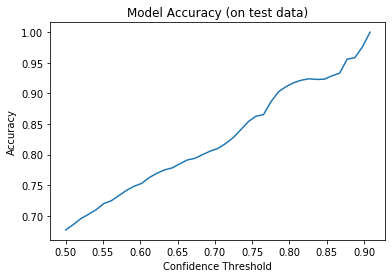

In [9]:
confident_accuracies = []
for p_threshold in np.linspace(0.5,1):
    accuracy = predictions_df[(predictions_df.prediction>p_threshold) | (predictions_df.prediction<1-p_threshold)]['correct'].mean()
    confident_accuracies.append(accuracy)

plt.plot(np.linspace(0.5,1),confident_accuracies)
plt.title('Model Accuracy (on test data)')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.savefig('model accuracy.jpeg',bbox_inches='tight')

## Set odds Data

In [10]:
use_best_odds = True # Or could code in to use a specific bookmaker

if use_best_odds:
    df[['A_odds','B_odds']] = df[['A_Max','B_Max']]
else:
    df[['A_odds','B_odds']] = df[['A_Avg','B_Avg']]

## Deciding When To Bet

In [11]:
betting_margin = 1.02
df["bet on A"]= (df["prediction"] > 1/df["A_odds"] * betting_margin)
df["bet on B"] = ((1-df["prediction"]) > 1/df["B_odds"] * betting_margin) 

## Calculating Returns

In [12]:
a_df = df.loc[df["bet on A"],:].copy()
b_df = df.loc[df["bet on B"],:].copy()

df.loc[df["bet on A"],'profit'] = a_df['y']*a_df["A_odds"] - 1
df.loc[df["bet on B"],'profit'] = (1-b_df['y'])*b_df["B_odds"] - 1

df.loc[df["bet on A"],'kelly_bet'] = (a_df["prediction"]*a_df["A_odds"]-1)/a_df["A_odds"]
df.loc[df["bet on B"],'kelly_bet'] = ((1-b_df["prediction"])*b_df["B_odds"]-1)/b_df["B_odds"]

print(df[df["bet on A"] | df["bet on B"]]['profit'].mean())

0.016040618955512564


In [13]:
kelly_profit = df[df["bet on A"] | df["bet on B"]]['kelly_bet'] * df[df["bet on A"] | df["bet on B"]]['profit']

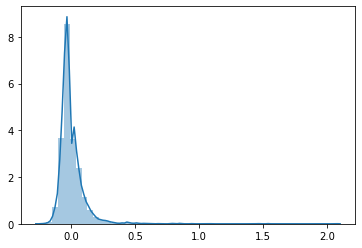

In [14]:
import seaborn as sns
sns.distplot(kelly_profit)

## Backtesting

Text(0.5, 1.0, 'Fractional P/L on Each Bet (mean = 5e-05)')

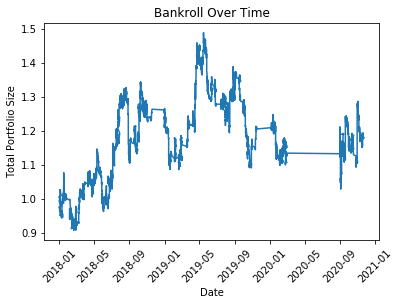

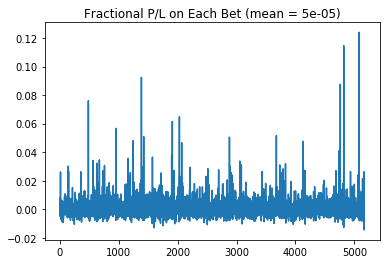

In [15]:
wallet = [1]
bet_p_and_l_fractional = []
betting_fraction_scale = 0.06

for index, x in df.iterrows():
    if x['bet on A'] or x['bet on B']:
        profit_or_loss_fraction = betting_fraction_scale*x['kelly_bet']*x['profit']
        wallet.append(wallet[-1] + wallet[-1]*profit_or_loss_fraction)
        bet_p_and_l_fractional.append(profit_or_loss_fraction)
    else:
        wallet.append(wallet[-1])
plt.plot(df.Date,wallet[1:])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Total Portfolio Size")
plt.title('Bankroll Over Time')
plt.savefig('bankroll.jpeg',bbox_inches='tight')

plt.figure()
plt.plot(bet_p_and_l_fractional)
plt.title('Fractional P/L on Each Bet (mean = {f})'.format(f=round(np.mean(bet_p_and_l_fractional),5)))

Text(0.5, 1.0, 'Bankroll Over Time')

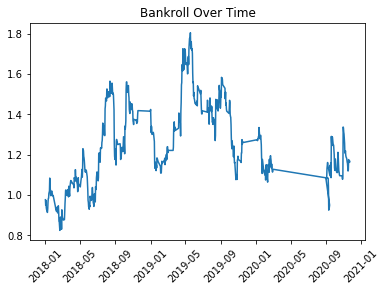

In [16]:
wallet = [1]
betting_fraction_scale = 0.1

for date,b_df in df.groupby('Date'):
    x = b_df.loc[b_df['bet on A'] | b_df['bet on B'],['kelly_bet','profit']]
    if x.shape[0]>0:
        total_fractional_bet = betting_fraction_scale*x['kelly_bet'].sum()
        total_fractional_profit = (betting_fraction_scale*x['kelly_bet']*x['profit']).sum()

        wallet.append(wallet[-1] + wallet[-1]*total_fractional_profit)
    else:
        wallet.append(wallet[-1])
        
plt.plot(df.Date.unique(),wallet[1:])
plt.xticks(rotation=45)
plt.title('Bankroll Over Time')